# Assignment 2 Yawei Li

## Q1 Research Question

In Genshin impact subreddit, why do sentiments on posts about a limited-time-only character drop after their rerun?

Background:

Genshin Impact is a multiplatform, open world game where players may gamble for playable characters with in-game or real-world currency. While some characters always have a chance to appear, most sought-after characters are only available in the lottery for a limited time period (usually 3 weeks). We call those 'limited characters', in comparison to 'regular characters'.

Sometimes, limited characters are up for re-run, meaning to be available in the gamble system again for 3 weeks, and the company would boost sales creating hype and by releasing challenges suitable for that rerun character. Typical reruns happen 6-9 months after a character's debut.

Genshin Impact subreddit is one of the biggest GI communities with 1.4 million followers. Then, it would be common sense to believe that when a character finally gets its rerun, sentiments on posts about him/her will remain high as players are excited about finally getting the character they've been waiting for (missed on first release/ joined after first release).

However, my sentiments data speaks otherwise. Sentiments on posts about rerun characters tend to drop down after initial soar,and sometimes even lower than previous levels.


## Q2 Data Collection

Obviously, this question needs Reddit data to answer. In specific, the project uses text data from GI subreddit posts titles and body.  However, I initially identified such patterns on Chinese GI forums. Since Chinese corpus is much harder to analyze and to interpret for English speaking audience, I choose to change question/data source to Reddit, and have found similar patterns.

I gathered said data using a Pushshift API (third party API for Reddit data) and 'psaw',an API wrapper for Pushshift.

I collect data by characters. For each character in question, I collect all posts found with Pushshift search. In addition to title and text, I also collected post date, statistics (upvotes, number of comments) and link to media/website if there's one. They may come useful in further work. I also collected character rerun periods for each character that has had an rerun.

## Q3 Data

In [43]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nlp
import matplotlib.pyplot as plt

In [46]:
#Loading data
data = pd.read_csv('data1.csv')
rrtimes = pd.read_csv('rrtimes.csv') #rerun time periods
data = data.merge(rrtimes, on = 'character',how = 'left') #Some character hasn't had rerun

In [48]:
data.shape

(81649, 12)

In [52]:
data.head()
#Selftext: Text from post body.
#Unnamed: index within character.

# Haven't finished all characters' rerun dates/status because large volume.
# Therefore rerun rows shown here for Klee is empty.
# Complete rows/head can be found as I do analysis with smaller data sets below.

,Unnamed: 0,created_utc,id,media_only,num_comments,score,selftext,title,url,character,rrstart,rrend
0,0,1635753223,qk94cb,False,3,1,NaN,*sad Childe simp noises*,https://i.redd.it/ikdhdbrmwxw71.jpg,Childe,NaN,NaN
1,1,1635750633,qk8mcu,False,0,1,NaN,F-free Childe? Mihoyo why would you do this?,https://v.redd.it/kgbhvs8uoxw71,Childe,NaN,NaN
2,2,1635750372,qk8k7p,False,2,1,NaN,really got me thinking i can claim my c1 childe,https://i.redd.it/iw307nrynxw71.png,Childe,NaN,NaN
3,3,1635745971,qk7l8k,False,3,1,[removed],Polar star Childe or SoH Hu tao?,https://www.reddit.com/r/Genshin_Impact/commen...,Childe,NaN,NaN
4,4,1635745185,qk7f3o,False,11,1,NaN,So childe having his boss material from his ow...,https://i.redd.it/vun2dp6q8xw71.jpg,Childe,NaN,NaN


Given large volume of data and limited work time after shifting to English data source, below demonstration would be done with a smaller pilot set. If that becomes an issue, I'll be happy to validate my findings on more complete set.

Full set has posts about 18 characters from 9 months. Pilot set has 5 characters from 1.5 months since 2022.

Character Zhongli, Ganyu and Xiao had their rerun during these 1.5 months while Albedo and Eula had reruns before 2022. 

In [85]:
# Loading pilot set with 
data = pd.read_csv('test1.csv')
rrtimes = pd.read_csv('rrtimes.csv')
data = data.merge(rrtimes, on = 'character',how = 'inner') # Characters in pilot set has all been rerun.

In [86]:
# Find Rerun Status at time of the post, rrstart and rrend are of same row/post/character as t.
def rrstatus(t,rrstart,rrend):
    if t<rrstart:
        return 'before'
    if t>rrend:
        return 'after'
    return 'on'

In [87]:
# Rerun preprocessing
data.rrstart = pd.to_datetime(data.rrstart)
data.rrend = pd.to_datetime(data.rrend)
data.created_utc = pd.to_datetime(data.created_utc,unit = 's')
data['rrstatus'] = data.apply(lambda x: rrstatus(x.created_utc, x.rrstart, x.rrend),axis = 1)
data = data[data.created_utc.dt.isocalendar().year == 2022]
# Had some 2021 data probably because of time zone difference, better solution later
data.shape

(5426, 13)

In [88]:
data.head()
# Selftext: Text from post body.
# Unnamed: index within character.
# rrstatus: Whether post is made before, after or on mentioned character's rerun.

,Unnamed: 0,created_utc,id,media_only,num_comments,score,selftext,title,url,character,rrstart,rrend,rrstatus
0,0,2022-01-11 00:14:48,s0yz6r,False,0,1,Ever since Zhongli joined my team on May 5th 2...,Can we talk about Character XP ?,https://www.reddit.com/r/Genshin_Impact/commen...,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before
1,1,2022-01-10 22:06:40,s0w0d4,False,1,1,[removed],Ganyu for Ayaka vs Zhongli for Hutao?,https://www.reddit.com/r/Genshin_Impact/commen...,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before
2,2,2022-01-10 20:05:14,s0t3pb,False,0,1,"Since both reruns are coming, which one is the...",Zhongli vs Kazuha,https://www.reddit.com/r/Genshin_Impact/commen...,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before
3,3,2022-01-10 19:57:10,s0swro,False,0,1,There's a common phrase I've seen on this subr...,Over reliance of Bennett in team comps?,https://www.reddit.com/r/Genshin_Impact/commen...,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before
4,4,2022-01-10 19:08:07,s0rrhy,False,1,1,NaN,Give your advices of how to build one of the b...,https://i.redd.it/jgvhkegrswa81.jpg,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before


In [89]:
sid = SentimentIntensityAnalyzer()
def sentiment_score(text):
    try:
        return sid.polarity_scores(text)['compound']
    except:
        # to handle cases where post don't have a body text
        return 0.0

In [90]:
data['stext'] = data['selftext'].apply(sentiment_score) #body text sentiment
data['stitle'] = data['title'].apply(sentiment_score) #title text sentiment

Note for row 1 and row 3 body text sentiment is extremely positive despite the author not being that happy, according to me reading the post. 

I therefore decided to use only title sentiment for this assignment. Still, body text will be extremely valuable in further research.

In [93]:
data.head()

,Unnamed: 0,created_utc,id,media_only,num_comments,score,selftext,title,url,character,rrstart,rrend,rrstatus,stext,stitle
0,0,2022-01-11 00:14:48,s0yz6r,False,0,1,Ever since Zhongli joined my team on May 5th 2...,Can we talk about Character XP ?,https://www.reddit.com/r/Genshin_Impact/commen...,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before,0.9116,0.5160
1,1,2022-01-10 22:06:40,s0w0d4,False,1,1,[removed],Ganyu for Ayaka vs Zhongli for Hutao?,https://www.reddit.com/r/Genshin_Impact/commen...,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before,0.0000,0.0000
2,2,2022-01-10 20:05:14,s0t3pb,False,0,1,"Since both reruns are coming, which one is the...",Zhongli vs Kazuha,https://www.reddit.com/r/Genshin_Impact/commen...,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before,0.9698,0.0000
3,3,2022-01-10 19:57:10,s0swro,False,0,1,There's a common phrase I've seen on this subr...,Over reliance of Bennett in team comps?,https://www.reddit.com/r/Genshin_Impact/commen...,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before,0.9489,0.0000
4,4,2022-01-10 19:08:07,s0rrhy,False,1,1,NaN,Give your advices of how to build one of the b...,https://i.redd.it/jgvhkegrswa81.jpg,Zhongli,2022-01-25 11:00:00,2022-02-15 17:59:00,before,0.0000,0.6369


In [103]:
data.score.describe()

count    5426.000000
mean        1.007188
std         0.150403
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: score, dtype: float64

In [125]:
data.groupby([data.character,data.rrstatus]).stitle.mean()

character  rrstatus
Albedo     after       0.078911
Eula       after       0.069235
Ganyu      after       0.027323
           before      0.121416
           on          0.137256
Xiao       after       0.114483
           before      0.090590
           on          0.109114
Zhongli    after       0.077709
           before      0.097727
           on          0.097342
Name: stitle, dtype: float64

## Q4 Demonstration

As can be seen from the two line plots below, all 3 characters in our pilot set has their post title sentiment dropped after their rerun, with the lowest points being below previous points.

In Figure 1, displayed by blue plot is character Xiao's post sentiment, averaged by week for clearer view with less daily noise/variance. Xiao's rerun lasted from Week 2 to Week 4, as marked by green dashed line in the picture. It can be seen that after peaking at week 4, sentiments dropped fast after the rerun was over at Week 5 and 6.

Text(0.5, 1.0, 'Figure 1 Character Xiao Post Sentiments by Week')

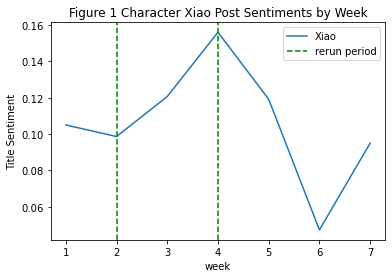

In [123]:
weeklychar = data.groupby([data.character,data.created_utc.dt.isocalendar().week]).mean()
weeklychar.loc['Xiao'].stitle.plot(label = 'Xiao')
plt.axvline(x = 2, color = 'green', linestyle = 'dashed',label = 'rerun period')
plt.axvline(x = 4, color = 'green', linestyle = 'dashed')
plt.ylabel('Title Sentiment')
plt.legend()
plt.title('Figure 1 Character Xiao Post Sentiments by Week')

Similar patterns can be found in Figure 2, where two Characters Zhongli and Ganyu had their rerun together following Xiao's, starting week 4. Compared to Figure 1, Zhongli and Ganyu's sentiment decline happened sooner. Ganyu's peaking and dropping is much more drastic than Zhongli's, probably because it was the second time that Zhongli returned for sale, while Xiao and Ganyu had their first rerun. It makes sense for Reddit users to have a less dramatic response to re-rerun than first comeback.

Text(0.5, 1.0, 'Figure 2 Character Ganyu/Zhongli Post Sentiments by Week')

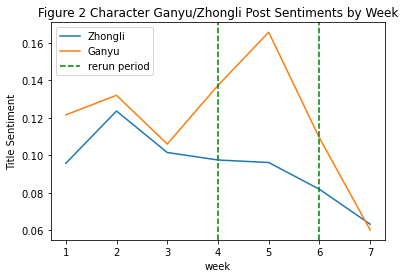

In [127]:
weeklychar.loc['Zhongli'].stitle.plot(label = 'Zhongli')
weeklychar.loc['Ganyu'].stitle.plot(label = 'Ganyu')
plt.axvline(x = 4, color = 'green', linestyle = 'dashed',label = 'rerun period')
plt.axvline(x = 6, color = 'green', linestyle = 'dashed')
plt.ylabel('Title Sentiment')
plt.legend()
plt.title('Figure 2 Character Ganyu/Zhongli Post Sentiments by Week')

In [131]:
pos_tagged_title = data['title'].apply(nlp.pos_tag)
pos_tagged_body = data['selftext'].fillna(' ').apply(nlp.pos_tag)

What caused such drop in sentiments? As time goes by, positive "lottery-win-sharing" posts drop in volume while neutral "gameplay disucssion" posts rise.

In early days (first week) of rerun, most players are doing the new lottery. Those over-thrilled at getting their desired character may then post to reddit to share their joy, causing a positive sentiment peak. As the rerun went on, the proportion of these getting-character posts dropped because most players have already finished their gambling. Instead, discussions of actual gameplay with their newly aquired character become more frequent, leading to sentiment becoming more calm/neutral. Besides, there may be more sad posts complaining not having enough currency to win the re-run character before he or she goes off shelf again, further lowering the average sentiment.

I elaborate above story with Lemma frequency comparison between Xiao ON rerun and AFTER rerun mainly by spotting the differences. First, the lemma 'pull' (playing the lottery / pulling character from reward pool) is the second most frequent (except for "Xiao" the character name, same below) on rerun, while dropped out of top 20 when the rerun was over. Same applys for 'get' (getting character), although ranked top on and after rerun, it's no longer leading by far after rerun. These could signify a drop in 'lottery-win-sharing' posts.

The second remarkable difference are: 3 Lemmas 'Lantern' ''s' 'Rite' became far more frequent after rerun. 'Lantern's Rite' is an in-game event where Xiao made an impressive appearance. Its rise in frequncy means gameplay discussion posts became more frequent.

In Pic 3 and Pic 4 of post body lemmas, similar arguments can be made, despite the data being much more noisy. 'Get' dropped by 100+ after rerun and 'pull' disappeared.

### Figure 3

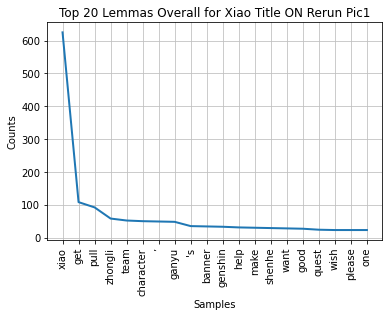

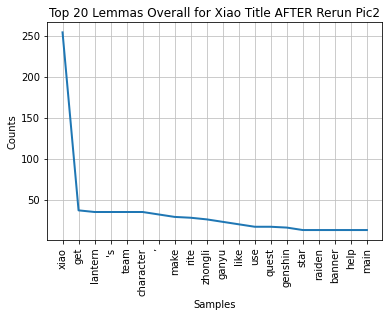

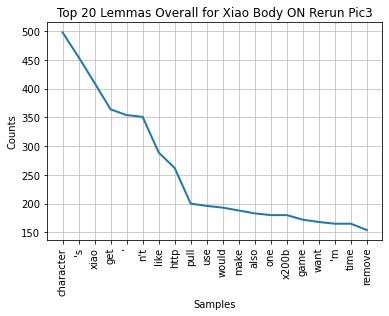

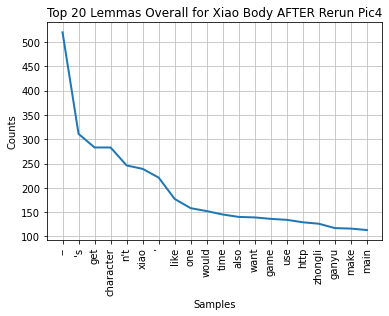

In [148]:
# Any way to put these nlp generated plots into an 2x2 grid?
nlp.plot_top_lemmas(data.title[(data.character == 'Xiao') & (data.rrstatus == 'on') ], 'Xiao Title ON Rerun Pic1')
nlp.plot_top_lemmas(data.title[(data.character == 'Xiao') & (data.rrstatus == 'after')], 'Xiao Title AFTER Rerun Pic2')
nlp.plot_top_lemmas(data.selftext.fillna(' ')[(data.character == 'Xiao') & (data.rrstatus == 'on') ], 'Xiao Body ON Rerun Pic3')
nlp.plot_top_lemmas(data.selftext.fillna(' ')[(data.character == 'Xiao') & (data.rrstatus == 'after')], 'Xiao Body AFTER Rerun Pic4')

### Figure 4

Similar argument applies to Ganyu's case, though to a less extent because her rerun just ended and data for after-rerun is relatively little. Apart from 'get' and 'pull', we can find 'lose' '50/50' making appearance in top20 after rerun. Lose 50/50 here means not getting Ganyu in the lottery system when the chance reached its peak 50%. Certainly I would expect such posts to be negative in sentiments.

Lemmas for body after rerun looks highly biased by a long theory crafting post, as 'equation', 'curve','rate' somehow appears in top 20. In next steps, it will be crucial to find ways to balance the effects of long posts where its key word may appear many times.

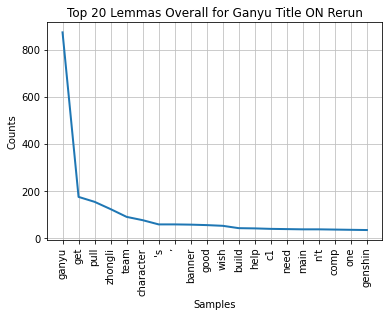

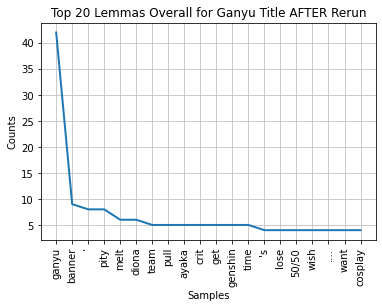

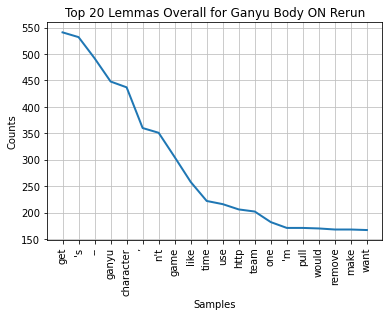

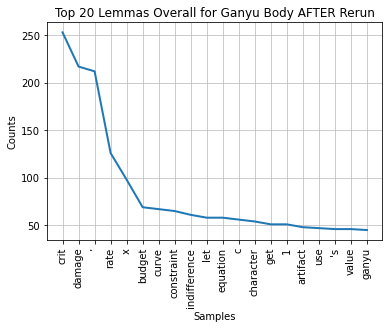

In [147]:
# Ganyu case, because Zhongli isn't that sensitive
nlp.plot_top_lemmas(data.title[(data.character == 'Ganyu') & (data.rrstatus == 'on') ], 'Ganyu Title ON Rerun')
nlp.plot_top_lemmas(data.title[(data.character == 'Ganyu') & (data.rrstatus == 'after')], 'Ganyu Title AFTER Rerun')
nlp.plot_top_lemmas(data.selftext.fillna(' ')[(data.character == 'Ganyu') & (data.rrstatus == 'on') ], 'Ganyu Body ON Rerun')
nlp.plot_top_lemmas(data.selftext.fillna(' ')[(data.character == 'Ganyu') & (data.rrstatus == 'after')], 'Ganyu Body AFTER Rerun')

### Legisign Explanation

I argued above that reddit post sentiment drops after reruns are, at least to some extent, because of volume shifts between 'lottery-win-sharing' posts and 'character gameplay' posts. The sign-vehicle here is the GI subreddit posts of both types. I now argue that these posts are replicas of a legisign of GI subreddit user community because: (1) Such posts have very high occurance on GI subreddit. (2) Together, GI subreddit users created a post tendency around character reruns. Supports for both points can be found above. Therefore, we can see posting these two types as general law for GI subreddit users. They pull, post 'lottery-win-sharing', then play and post 'character gameplay'. These posts are iconic to the object, game experience of playing lottery or playing with their characters, as their posts usually describe such experience. They can also be indexical, pointing towards certain characters. The relationship between sign-vehicle and interpretant is context dependant, but mostly dicentic or argumentative, because the interpretant is constantly 'I want to share this ... (post content) to fellow GI players', and sometimes to further argue 'I'm so lucky/unlucky' or 'Xiao is such a cool character' etc.

Another legisign that the sentiment drop phenomenon consists is a in-game currency spending style of general GI players, not limited to just Reddit users: players save in-game currencies before the rerun of their desired character, and pull immediately after their re-release. Such save-pull patterns are self-explanatory, but are very common among GI players including myself, causing the sentiment peak of 'winning-lottery-posts' soon after rerun. Sign-vehicle here is the save-pull pattern, with indexical relationship to game economy and rerun schedule and argumentative relationship to its interpretant: I save and pull for my favorite so that I can get him/her 100% right upon rerun.

## Q5 Further Steps

First, I would clean the processes employed in this pilot. This includes to better clean and preprocess data, to remove stopwords from Lemmas. and to organize plots on axes, etc. I'll emphasize on making a data pipeline scalable to size of full data set.

Second, I would expand my pilot research to the full dataset to validate 'sentiment drop after rerun' phenomenon and 'post volume shift' explanation. With more characters analyzed, I can achieve more robust conclusions or find new patterns.

Third, I would further expand my analysis methods. The 'lottery-win-sharing' post and 'character gameplay' post dichotonomy signals great potential for LDA analysis or for classifier training. Besides, NLTK's performance on Genshin Impact data isn't very satisfactory, maybe by looking into NLP field, I find ways to calculate better sentiments or find better lemmas.

Fourth, I would attempt to develop a web-based interactive GI subreddit analyzer. This goal is less about the course and more about development and personal interest. To put this in my portofolio would greatly help my pursuit for data scientist/analyst career.

## Misc 

In [101]:
weeklycount = data.groupby([data.character,data.created_utc.dt.isocalendar().week]).count()
weeklycount

Unnamed: 0  created_utc   id  media_only  num_comments  score  \
character week                                                                  
Albedo    1             62           62   62          62            62     62   
          2             63           63   63          63            63     63   
          3             44           44   44          44            44     44   
          4             46           46   46          46            46     46   
          5             36           36   36          36            36     36   
          6             27           27   27          27            27     27   
          7             24           24   24          24            24     24   
Eula      1             98           98   98          98            98     98   
          2             70           70   70          70            70     70   
          3             57           57   57          57            57     57   
          4             66           66   66          66            66     66   
          5             47           47   47          47            47     47   
          6             37           37   37          37            37     37   
          7             39           39   39          39            39     39   
Ganyu     1            220          220  220         220           220    220   
          2            203          203  203         203           203    203   
          3            185          185  185         185           185    185   
          4            535          535  535         535           535    535   
          5            295          295  295         295           295    295   
          6            219          219  219         219           219    219   
          7            128          128  128         128           128    128   
Xiao      1            446          446  446         446           446    446   
          2            265          265  265         265           265    265   
          3            169          169  169         169           169    169   
          4            156          156  156         156           156    156   
          5            102          102  102         102           102    102   
          6             86           86   86          86            86     86   
          7             75           75   75          75            75     75   
Zhongli   1            222          222  222         222           222    222   
          2            198          198  198         198           198    198   
          3            196          196  196         196           196    196   
          4            417          417  417         417           417    417   
          5            308          308  308         308           308    308   
          6            172          172  172         172           172    172   
          7            113          113  113         113           113    113   

                selftext  title  url  rrstart  rrend  rrstatus  stext  stitle  
character week                                                                 
Albedo    1           48     62   62       62     62        62     62      62  
          2           37     63   63       63     63        63     63      63  
          3           26     44   44       44     44        44     44      44  
          4           32     46   46       46     46        46     46      46  
          5           28     36   36       36     36        36     36      36  
          6           18     27   27       27     27        27     27      27  
          7           18     24   24       24     24        24     24      24  
Eula      1           63     98   98       98     98        98     98      98  
          2           34     70   70       70     70        70     70      70  
          3           35     57   57       57     57        57     57      57  
          4           40     66   66       66     66      

In [97]:
dailychar = data.groupby([data.character,data.created_utc.dt.date]).mean()
dailychar.shape

(238, 6)

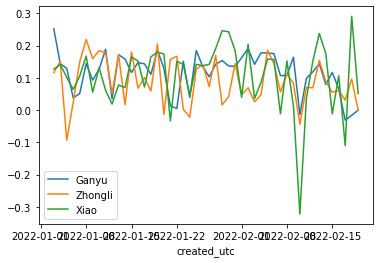

In [98]:
dailychar = data.groupby([data.character,data.created_utc.dt.date]).mean()
dailychar.loc['Ganyu'].stitle.plot(label = 'Ganyu')
dailychar.loc['Zhongli'].stitle.plot(label = 'Zhongli')
dailychar.loc['Xiao'].stitle.plot(label = 'Xiao')
plt.legend()

Text(0.5, 1.0, 'Figure 1 Character Xiao Body Sentiments by Week')

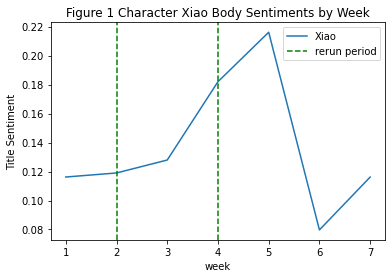

In [149]:
weeklychar.loc['Xiao'].stext.plot(label = 'Xiao')
plt.axvline(x = 2, color = 'green', linestyle = 'dashed',label = 'rerun period')
plt.axvline(x = 4, color = 'green', linestyle = 'dashed')
plt.ylabel('Title Sentiment')
plt.legend()
plt.title('Figure 1 Character Xiao Body Sentiments by Week')

Text(0.5, 1.0, 'Figure 2 Character Ganyu/Zhongli Body Sentiments by Week')

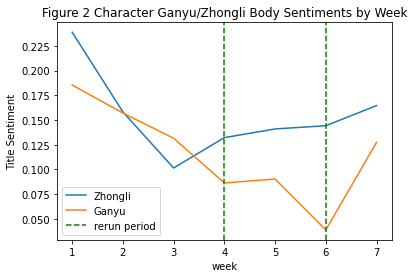

In [144]:
weeklychar.loc['Zhongli'].stext.plot(label = 'Zhongli')
weeklychar.loc['Ganyu'].stext.plot(label = 'Ganyu')
plt.axvline(x = 4, color = 'green', linestyle = 'dashed',label = 'rerun period')
plt.axvline(x = 6, color = 'green', linestyle = 'dashed')
plt.ylabel('Title Sentiment')
plt.legend()
plt.title('Figure 2 Character Ganyu/Zhongli Body Sentiments by Week')